In [1]:
from utils_v1 import *
from icecream import ic
import pdb

# root_path = 'F:/Doctorado/Deforestation_SAR/Tensorflow2/INPE_Project/'
root_path = 'D:/jorg/phd/fifth_semester/project_forestcare/data/'

In [2]:
# Loading images
image_stack = np.load(root_path+'filt_norm_img_2019_2020.npy')

# Loading reference
label_mask = np.load(root_path+'label_mask_2019_2020.npy')

print('image shape: ', '\n', image_stack.shape, '\n', 'reference shape: ', '\n', label_mask.shape)

# Print pertengate of each class (whole image)
no_def = len(label_mask[label_mask==0])
def_ = len(label_mask[label_mask==1])
pt_def = len(label_mask[label_mask==2])
print('Percentage of deforestaion class is {:.2f}'.format((def_*100)/(label_mask.shape[0]*label_mask.shape[1])))
print('Percentage of no-deforestaion class is {:.2f}'.format((no_def*100)/(label_mask.shape[0]*label_mask.shape[1])))
print('Percentage of past-deforestaion class is {:.2f}'.format((pt_def*100)/(label_mask.shape[0]*label_mask.shape[1])))

image shape:  
 (5013, 5003, 14) 
 reference shape:  
 (5013, 5003)
Percentage of deforestaion class is 0.15
Percentage of no-deforestaion class is 76.99
Percentage of past-deforestaion class is 22.85


In [3]:
# Creating tile mask
grid_x, grid_y = 5,5
mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], grid_size=(grid_x, grid_y))
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)

Tiles size:  1002 1000
Mask size:  (5010, 5000)
mask:  (5010, 5000)
image stack:  (5010, 5000, 14)
ref : (5010, 5000)


ic| np.unique(label_mask, return_counts=True): (array([0., 1., 2.], dtype=float32),
                                                array([19283359,    38430,  5728211], dtype=int64))
ic| np.unique(label_mask): array([0., 1., 2.], dtype=float32)
ic| np.unique(label_mask_current_deforestation): array([0., 1.], dtype=float32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


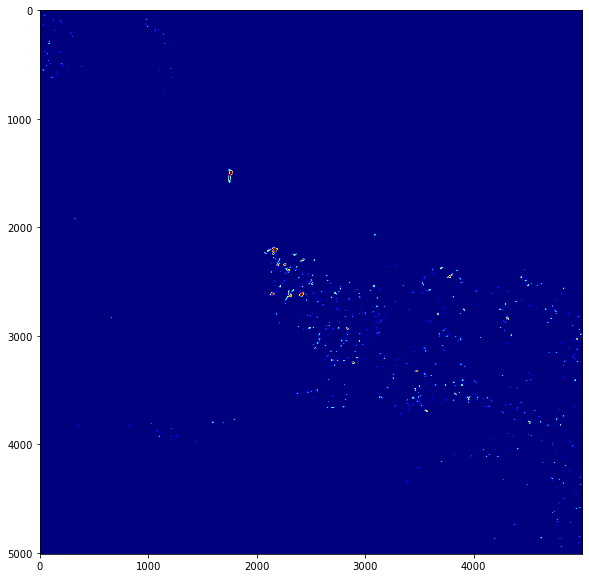

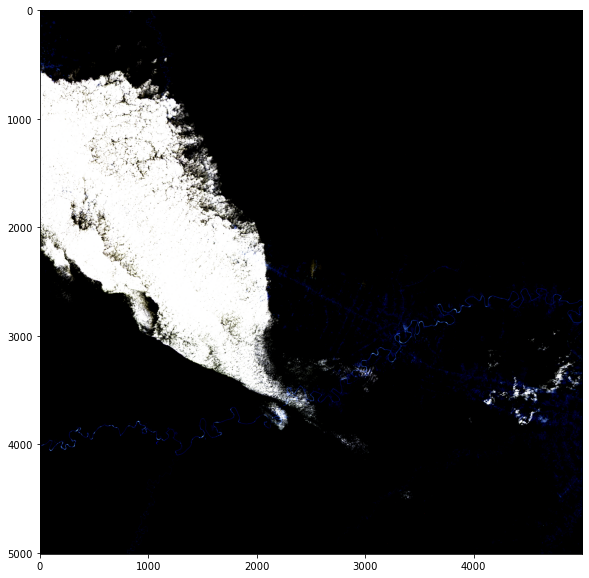

In [4]:
selected_class = 1
#plt.figure(figsize=(10,10))
#plt.imshow(label_mask, cmap = 'jet')
ic(np.unique(label_mask, return_counts=True))
# , cmap = 'jet'
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation == selected_class] = 10
label_mask_current_deforestation[label_mask_current_deforestation != 10] = 0
label_mask_current_deforestation[label_mask_current_deforestation == 10] = 1

plt.figure(figsize=(10,10))

ic(np.unique(label_mask))
ic(np.unique(label_mask_current_deforestation))
plt.imshow(label_mask_current_deforestation, cmap = 'jet')
plt.savefig('label_class' + str(selected_class) + '.png')
plt.figure(figsize=(10,10))
plt.imshow(image_stack[..., 0:3], cmap = 'jet')


In [5]:
# Defining tiles for training, validation and test sets
tiles_tr = [2,4,5,6,7,12,14,15,18,21,23,24] 
tiles_val = [9,11,25]
tiles_ts = list(set(np.arange(grid_x * grid_y)+1)-set(tiles_tr)-set(tiles_val))
    
print('Training tiles: ', tiles_tr)
print('Validation tiles: ', tiles_val)
print('Test tiles: ', tiles_ts)

# Training and validation mask
mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')

for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [6]:
overlap = 0.75
patch_size = 128
batch_size = 32
im_idx = create_idx_image(label_mask)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [7]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training and validation patches:  ', len(patches_idx_trn), len(patches_idx_val))

Number of training and validation patches:   9787 2268


In [8]:
# Keeping patches with 2% of def class
X_train = retrieve_idx_percentage(label_mask, patches_idx_trn, patch_size, pertentage = 0.2)
X_valid = retrieve_idx_percentage(label_mask, patches_idx_val, patch_size, pertentage = 0.2)
print('training samples: ', X_train.shape, 'validation samples: ', X_valid.shape)

training samples:  (924, 128, 128) validation samples:  (275, 128, 128)


In [9]:
# Creating train and validation data generator
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3
train_gen_crops = batch_generator(train_gen, image_stack, label_mask, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_stack, label_mask, patch_size, number_class)

In [10]:
exp = 0
path_exp = root_path+'Experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet_dropout'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [11]:
metrics_all = []
training = False
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        channels = image_stack.shape[-1]
        adam = Adam(lr = 1e-3 , beta_1=0.9)

        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout2(input_shape, nb_filters, number_class)
#        model = build_unet_dropout(input_shape, nb_filters, number_class)

        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_crops,
                                  steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                                  validation_data=valid_gen_crops,
                                  validation_steps=len(X_valid)*3//valid_gen.batch_size,
                                  epochs=100,
                                  callbacks=callbacks_list)
        end_training = time.time() - start_training
        metrics_all.append(end_training)
        del model, history

    # Saving training time
    np.save(path_exp+'/metrics_tr.npy', metrics_all)

In [12]:
#%% Test loop
metrics_ts = []
n_pool = 4
n_rows = 5
n_cols = 5
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack
h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

# new_model = build_resunet_dropout2(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3)

metrics_all =[]
ic(patch_size_rows, patch_size_cols)

-30.0 -40.0


ic| patch_size_rows: 1008, patch_size_cols: 1008


(1008, 1008)

In [13]:


times = 10
ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)

save_probabilities = False
class_n = 3
if save_probabilities == False:
#    prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, times), dtype = np.float32)
    prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)
for tm in range(0,times):
    print('time: ', tm)
    
    
    start_test = time.time()
    patch_t = []
    
    new_model = build_resunet_dropout2(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3, seed = tm)    
#    new_model = build_unet_dropout(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3, seed = tm)    

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())

    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1]) 
            del predictions_
    ts_time =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)
    del patch_t
    # Recinstructing predicted map
    
    prob_reconstructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    prob_rec[:,:,tm] = prob_reconstructed
    if save_probabilities == True:
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
        
    metrics_all.append(ts_time)
    del patches_pred, prob_reconstructed
metrics_ = np.asarray(metrics_all)

# Saving test time
np.save(path_exp+'/metrics_ts.npy', metrics_)

ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/jorg/phd/fifth_semester/project_forestcare/data/Experiments/exp0/models/resunet_dropout_0.h5'


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


ic| prob_rec.shape: (5040, 5040, 10), prob_rec.dtype: dtype('float32')
ic| std_prob.shape: (5040, 5040)


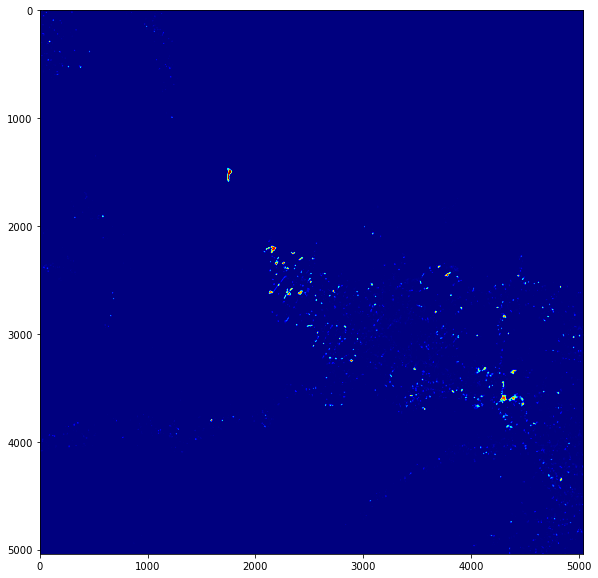

In [14]:
if save_probabilities == True:
    prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times), dtype = np.float32)
    for tm in range (0, times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)
selected_class = 1


ic(prob_rec.shape, prob_rec.dtype)
mean_prob = np.mean(prob_rec, axis = -1)

ic(std_prob.shape)
np.save(path_maps+'/prob_mean.npy', mean_prob)

fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.savefig('mean_prob_class'+str(selected_class)+'.png')



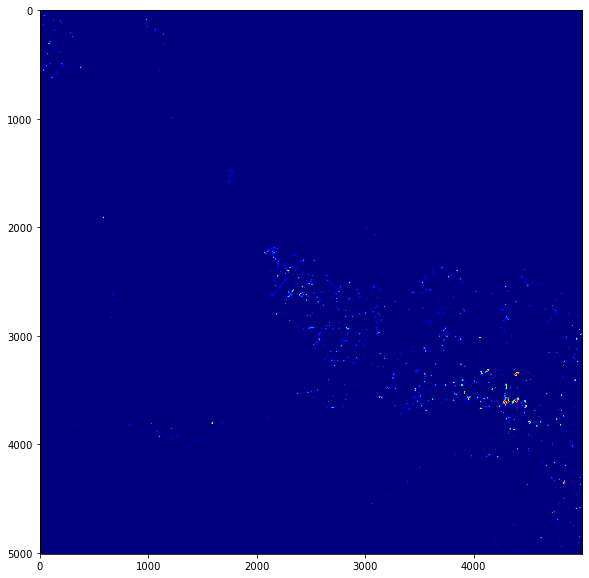

In [16]:
error_areas = np.abs(mean_prob_thresh - label_mask_current_deforestation)
np.unique(error_areas, return_counts = True)

fig2 = plt.figure(figsize=(10,10))
plt.imshow(error_areas, cmap = 'jet')

In [20]:
ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))

ic| prob_rec.shape: (5040, 5040, 10)


In [21]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [22]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 5040, 5040, 1)


(10, 5040, 5040, 1)

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k]) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k]) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + 1e-15)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

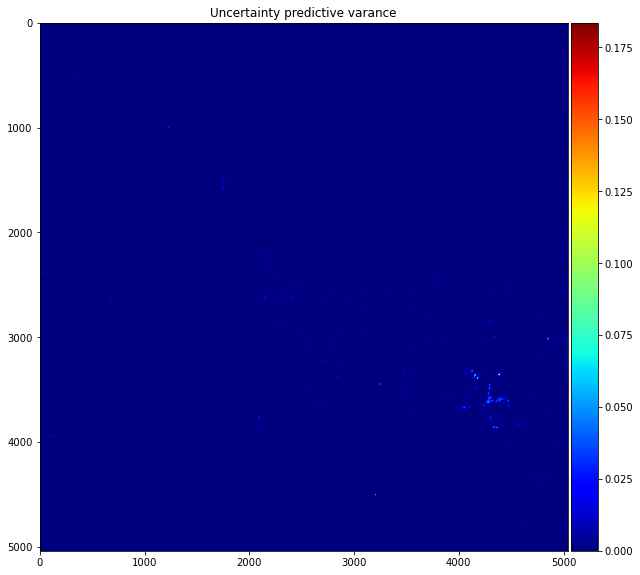

In [31]:
pred_var = predictive_variance(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive varance')


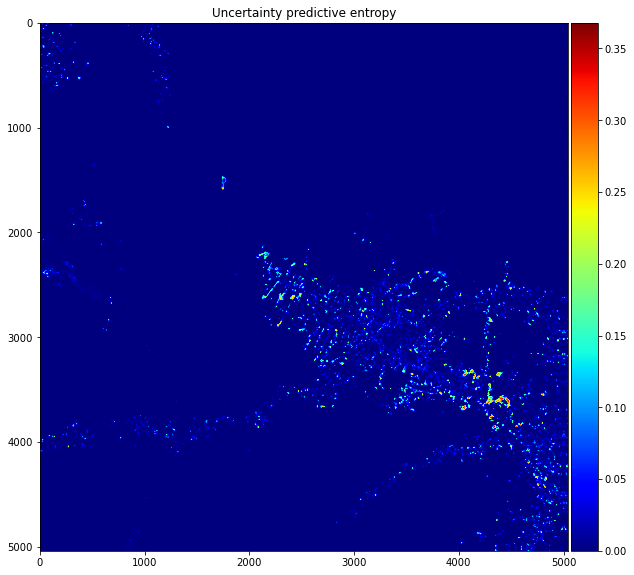

In [32]:
pred_entropy = predictive_entropy(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy, ax, title = 'Uncertainty predictive entropy')


ic| pred_entropy.shape: (5040, 5040)


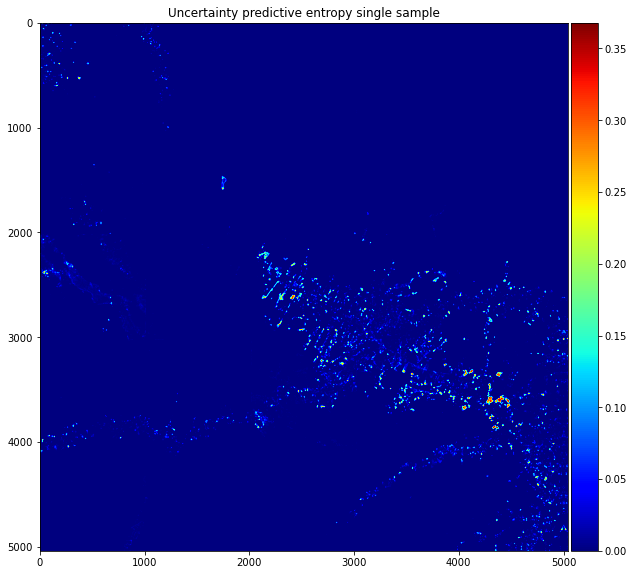

In [33]:
pred_entropy_single = single_experiment_entropy(prob_rec[0])

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')


ic| n: 10, K: 1
ic| np.count_nonzero(np.isnan(MI)): 0


0

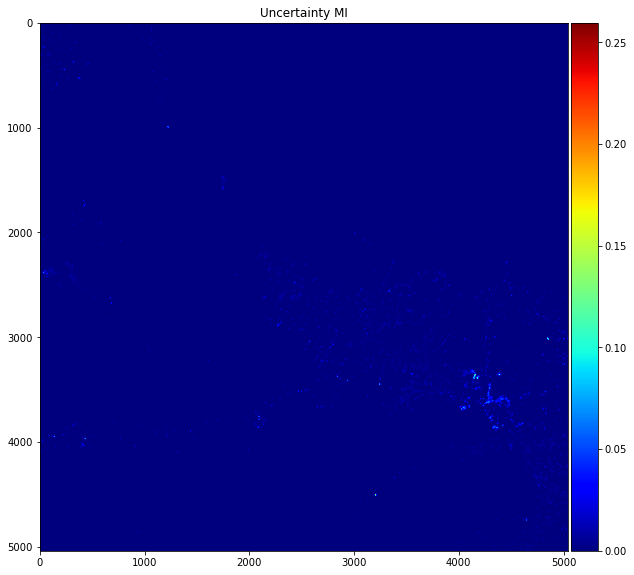

In [29]:


MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')


In [ ]:
'''
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1

# Number of thresholds to generate the curve    
Npoints = 6
Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)
    
metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 69)
np.save(path_exp+'/acc_metrics.npy',metrics_)
'''

In [ ]:
'''
# Complete NaN values
metrics_copy = metrics_.copy()
metrics_copy = complete_nan_values(metrics_copy)
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]

# Generating mAP curve
mAP = Area_under_the_curve(Recall, Precision)
print('mAP: ', mAP)

plt.close('all')
plt.plot(Recall, Precision)
plt.grid()
'''